In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from mamba_ssm import Mamba
from torch_geometric.nn import GCNConv

# ============ Set Seed ============
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ============ Dataset ============
import torch
from torch.utils.data import Dataset, DataLoader

class Twitter15Dataset(Dataset):
    def __init__(self, graph_data_list):
        self.graphs = graph_data_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx]
        x = graph['x']
        edge_index = graph['edge_index']
        y = graph['y']
        idx2id = graph.get('idx2id')

        return x, edge_index, y, idx2id

def collate_fn(batch):
    xs, edge_indices, ys, idx2ids = zip(*batch)

    max_len = max(x.shape[0] for x in xs)  # find max sequence length in batch
    feature_dim = xs[0].shape[1]

    padded_xs = []
    masks = []
    edge_indices_new = []

    for i, (x, edge_index) in enumerate(zip(xs, edge_indices)):
        seq_len = x.shape[0]
        pad_len = max_len - seq_len

        if pad_len > 0:
            pad = torch.zeros((pad_len, feature_dim), dtype=x.dtype)
            x_padded = torch.cat([x, pad], dim=0)
        else:
            x_padded = x

        mask = torch.cat([torch.ones(seq_len), torch.zeros(pad_len)]).bool()

        padded_xs.append(x_padded)
        masks.append(mask)

        # 对 edge_index 做偏移（batch中每个graph单独编号）
        edge_index_offset = edge_index.clone()
        edge_index_offset += i * max_len
        edge_indices_new.append(edge_index_offset)

    padded_xs = torch.stack(padded_xs)    # (batch_size, max_len, feature_dim)
    masks = torch.stack(masks)             # (batch_size, max_len)
    ys = torch.tensor(ys)                  # (batch_size,)
    batch_edge_index = torch.cat(edge_indices_new, dim=1)  # (2, total_edges)

    return padded_xs, masks, batch_edge_index, ys

# ============ Model ============

class GraphEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gcn = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, mask, edge_index):
        """
        x: (B, L, D)
        mask: (B, L) True=真实节点
        edge_index: (2, E) — 你拼好的大图
        """
        B, L, D = x.size()
        x_flat = x.view(B * L, D)                       # (B*L, D)

        # flatten mask
        mask_flat = mask.view(B * L)                    # (B*L,)
        mask_f   = mask_flat.unsqueeze(-1).to(x_flat.dtype)  

        # 先把 padding feature 确保为 0
        x_flat = x_flat * mask_f

        # GCN 卷积
        if edge_index.numel() > 0:
            h_flat = self.gcn(x_flat, edge_index)
        else:
            h_flat = x_flat

        # 再次把 padding 的输出置零
        h_flat = h_flat * mask_f

        # 恢复形状
        h = h_flat.view(B, L, D)
        return h

class MambaLayer(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super().__init__()
        self.mamba   = Mamba(d_model=hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # 只喂 x 给 Mamba
        x = self.mamba(x)
        x = self.dropout(x)
        return x


class MambaEncoder(nn.Module):
    def __init__(self, input_dim=833, hidden_dim=128, num_layers=2, dropout_rate=0.2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.layers     = nn.ModuleList([
            MambaLayer(hidden_dim, dropout_rate)
            for _ in range(num_layers)
        ])
        self.norm       = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask):
        """
        x:    (B, L, input_dim)
        mask: (B, L)   bool tensor, True 表示真实 token
        """
        # 1) 投影 + 首次屏蔽 padding
        x = self.input_proj(x)                          # -> (B, L, D)
        mask_f = mask.unsqueeze(-1).to(x.dtype)         # -> (B, L, 1)
        x = x * mask_f                                  # padding 位置全 0

        # 2) 每层 Mamba 后再屏蔽一次
        for layer in self.layers:
            x = layer(x)                                # Mamba + Dropout
            x = x * mask_f                              # 确保 padding 不累积噪声

        # 3) 归一化
        x = self.norm(x)
        return x

class MeanPooling(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, mask):
        mask = mask.unsqueeze(-1)
        x = x * mask
        sum_x = x.sum(dim=1)
        lengths = mask.sum(dim=1)
        pooled = sum_x / lengths.clamp(min=1e-6)
        return pooled

class ClassifierHead(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

class MambaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.norm        = nn.LayerNorm(input_dim)
        self.encoder     = MambaEncoder(input_dim, hidden_dim, num_layers)
        self.gnn_encoder = GraphEncoder(hidden_dim)
        self.pooling     = MeanPooling()
        self.classifier  = ClassifierHead(hidden_dim, num_classes)

    def forward(self, x, mask, edge_index):
        # x: (B, L, D), mask: (B, L), edge_index: (2, E)
        x = self.norm(x)
        h_seq   = self.encoder(x, mask)
        # 这里把 mask 一并传给 GCN
        h_graph = self.gnn_encoder(h_seq, mask, edge_index)
        h       = h_seq + 0.3 * h_graph
        pooled  = self.pooling(h, mask)
        logits  = self.classifier(pooled)
        return torch.clamp(logits, min=-10, max=10)

# ============ Causal Discovery Module (NOTEARS-based) ============
import torch
import torch.nn as nn
import torch.optim as optim

def causal_discovery_loss(hiddens, lambda_sparse=1.0, lambda_dag=1.0):
    """
    Simplified causal discovery loss from hidden representations.
    Only uses the first graph in the batch to avoid batch dimension issue.
    """
    h = hiddens[0]  # (L, D)
    L, D = h.shape

    W = torch.matmul(h, h.T) / D  # (L, L)

    loss_recon = ((h - torch.matmul(W, h)) ** 2).mean()  # Reconstruction Loss

    loss_sparse = W.abs().mean()  # Sparsity

    loss_acyclic = torch.trace(torch.matrix_exp(W * W)) - L  # Acyclicity

    causal_loss = loss_recon + lambda_sparse * loss_sparse + lambda_dag * loss_acyclic

    return causal_loss

# ============ Loss Function ============
def smooth_cross_entropy(preds, targets, smoothing=0.1):
    confidence = 1.0 - smoothing
    logprobs = F.log_softmax(preds, dim=-1)
    nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
    smooth_loss = -logprobs.mean(dim=-1)
    loss = confidence * nll_loss + smoothing * smooth_loss
    return loss.mean()

# ============ Causal Loss Function ============
def causal_loss(adj_matrix, lambda_sparse=0.01):
    """
    Calculate causal loss: encourage sparsity and acyclicity
    """
    L = adj_matrix.size(0)
    h_A = torch.trace(torch.matrix_exp(adj_matrix * adj_matrix)) - L
    sparse_loss = lambda_sparse * adj_matrix.abs().sum()
    return h_A + sparse_loss

# ============ Training & Evaluation ============

def train_one_epoch_joint(model, train_loader, optimizer, loss_fn, device, lambda_causal=1.0):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_idx, (x, mask, edge_index, y) in enumerate(train_loader):
        x, mask, y = x.to(device), mask.to(device), y.to(device)
        edge_index = edge_index.to(device)

        x = torch.nan_to_num(x, nan=0.0)

        optimizer.zero_grad()

        # Forward
        logits = model(x, mask, edge_index)
        logits = torch.clamp(logits, min=-10, max=10)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            continue

        # Classification Loss
        classification_loss = loss_fn(logits, y)

        # Causal Discovery Loss (new)
        hiddens = model.encoder(x, mask)
        causal_loss_value = causal_discovery_loss(hiddens, lambda_sparse=1.0, lambda_dag=1.0)

        # Total Loss
        loss = classification_loss + lambda_causal * causal_loss_value
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(y.cpu().tolist())

        # 每个 batch 打印一次
        # if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
        #     print(f"  Batch {batch_idx+1}/{len(train_loader)}:")
        #     print(f"    Classification Loss: {classification_loss.item():.4f}")
        #     print(f"    Causal Loss: {causal_loss_value.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc, epoch_f1

def evaluate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, mask, edge_index, y in val_loader:
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            edge_index = edge_index.to(device)

            logits = model(x, mask, edge_index)
            logits = torch.clamp(logits, min=-10, max=10)

            if torch.isnan(logits).any() or torch.isinf(logits).any():
                continue

            loss = loss_fn(logits, y)

            running_loss += loss.item() * x.size(0)

            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc, epoch_f1
    
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_f1 = -float('inf')

    def __call__(self, val_f1, model, save_path):
        score = val_f1
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1, model, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1, model, save_path)
            self.counter = 0

    def save_checkpoint(self, val_f1, model, save_path):
        torch.save(model.state_dict(), save_path)
        self.best_f1 = val_f1

In [3]:
import torch
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

# ============ Set fixed parameters ============
batch_size = 16
hidden_dim = 128
num_layers = 2
num_classes = 4
max_epochs = 1000
patience = 10
lambda_causal = 0.1  # 超参数，可调（越大，因果约束越强）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============ Load dataset ============
graph_data_list = torch.load("../processed/twitter15_graph_data_clean.pt", weights_only=False)

# split Train/Val/Test (7:1:1)
train_graphs, temp_graphs = train_test_split(graph_data_list, test_size=0.3, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# Dataset
train_dataset = Twitter15Dataset(train_graphs)
val_dataset = Twitter15Dataset(val_graphs)
test_dataset = Twitter15Dataset(test_graphs)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ============ Define hyperparameter grid ============
grid_params = {
    'lr': [5e-5],
    'weight_decay': [5e-2]
}

best_val_f1 = -float('inf')
best_params = None

Train: 1043, Val: 223, Test: 224


In [3]:
# ============ Grid Search ============
for lr in grid_params['lr']:
    for wd in grid_params['weight_decay']:
        print(f"\nTrying lr={lr}, weight_decay={wd}")

        model = MambaClassifier(input_dim=833, hidden_dim=128, num_layers=2, num_classes=4).to('cuda')
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
        loss_fn = smooth_cross_entropy
        early_stopper = EarlyStopping(patience=10, verbose=True)

        save_path = "../checkpoints/best_model_causal_v1_temp.pt"

        for epoch in range(1, 1001):
            train_loss, train_acc, train_f1 = train_one_epoch_joint(
                model, train_loader, optimizer, loss_fn, 'cuda', lambda_causal=1.0)
            val_loss, val_acc, val_f1 = evaluate_one_epoch(model, val_loader, loss_fn, 'cuda')

            print(f"Epoch {epoch}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val   F1: {val_f1:.4f}")

            early_stopper(val_f1, model, save_path)
            if early_stopper.early_stop:
                print("Early stopping triggered!")
                break

        if early_stopper.best_f1 > best_val_f1:
            best_val_f1 = early_stopper.best_f1
            best_params = {'lr': lr, 'weight_decay': wd}
            torch.save(model.state_dict(), "../checkpoints/best_model_causal_v1.pt")

print("\nGrid Search Completed!")
print(f"Best Params: {best_params}, Best Val F1: {best_val_f1:.4f}")


Trying lr=5e-05, weight_decay=0.05
Epoch 1:
  Train Loss: 1.5283 | Train Acc: 0.2397 | Train F1: 0.2154
  Val   Loss: 1.2858 | Val   Acc: 0.3092 | Val   F1: 0.2504
Epoch 2:
  Train Loss: 1.3819 | Train Acc: 0.3413 | Train F1: 0.3075
  Val   Loss: 1.2815 | Val   Acc: 0.3623 | Val   F1: 0.3611
Epoch 3:
  Train Loss: 1.3705 | Train Acc: 0.3969 | Train F1: 0.3527
  Val   Loss: 1.2619 | Val   Acc: 0.3527 | Val   F1: 0.3078
EarlyStopping counter: 1 out of 10
Epoch 4:
  Train Loss: 1.3409 | Train Acc: 0.4506 | Train F1: 0.3971
  Val   Loss: 1.2528 | Val   Acc: 0.3285 | Val   F1: 0.2960
EarlyStopping counter: 2 out of 10
Epoch 5:
  Train Loss: 1.3089 | Train Acc: 0.4813 | Train F1: 0.4319
  Val   Loss: 1.2420 | Val   Acc: 0.3333 | Val   F1: 0.2979
EarlyStopping counter: 3 out of 10
Epoch 6:
  Train Loss: 1.3340 | Train Acc: 0.5014 | Train F1: 0.4485
  Val   Loss: 1.2221 | Val   Acc: 0.4106 | Val   F1: 0.3632
Epoch 7:
  Train Loss: 1.2663 | Train Acc: 0.5149 | Train F1: 0.4704
  Val   Loss: 1.

Loaded model from checkpoint!
 Test Accuracy: 0.5670
 Test Macro-F1: 0.5676


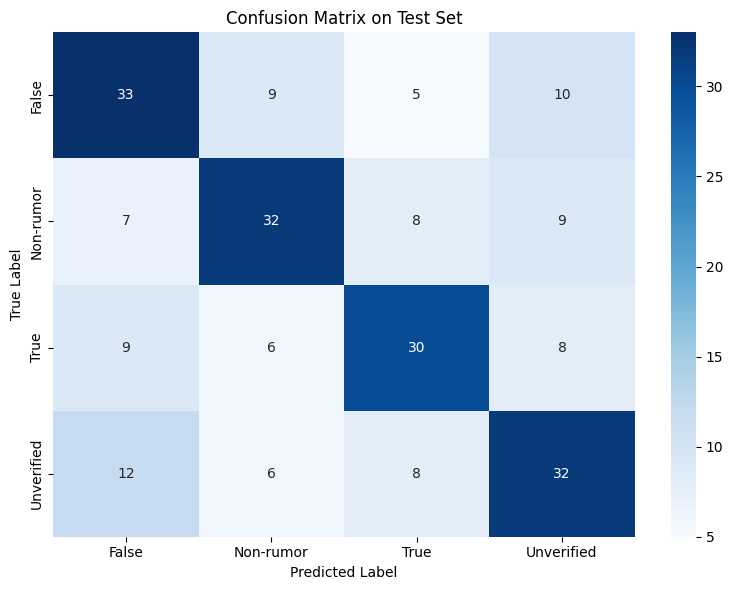

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import networkx as nx

# Load the best causal model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MambaClassifier(input_dim=833, hidden_dim=128, num_layers=2, num_classes=4).to(device)
model.load_state_dict(torch.load("../checkpoints/best_model_causal_v1.pt", map_location=device))
print("Loaded model from checkpoint!")
model.to(device)
model.eval()

all_preds = []
all_labels = []
all_hiddens = []

with torch.no_grad():
    for x, mask, edge_index, y in test_loader:
        x = x.to(device)
        mask = mask.to(device)
        edge_index = edge_index.to(device)
        y = y.to(device)

        logits = model(x, mask, edge_index)
        preds = logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

        # Also collect hidden states
        hiddens = model.encoder(x, mask)
        pooled_h = model.pooling(hiddens, mask)
        all_hiddens.append(pooled_h.cpu())

# Stack hidden states
all_hiddens = torch.cat(all_hiddens, dim=0)  # (N, D)

# Compute Test Metrics
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')
print(f" Test Accuracy: {test_acc:.4f}")
print(f" Test Macro-F1: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["False", "Non-rumor", "True", "Unverified"],
            yticklabels=["False", "Non-rumor", "True", "Unverified"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


========= Found a Rumor! Event 17 =========
Predicted: 1, Probs: [0.01038591 0.936049   0.03779    0.01577512]
Intervention points [331, 322, 39]


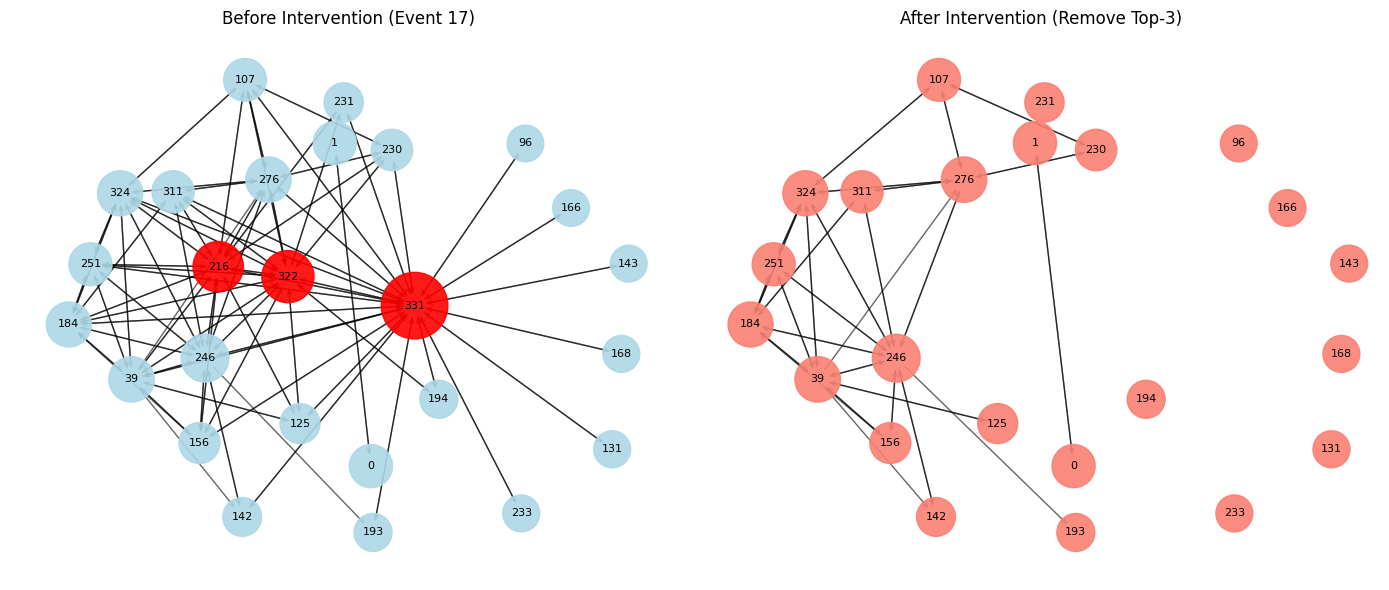


===== Node Index → Twitter ID =====
Idx  | Twitter ID
------------------------------
0   → ('507918114567499776',)
1   → ('507918114567499776',)
39  → ('507918470391267328',)
96  → ('507919218890006528',)
107 → ('507919287731105792',)
125 → ('507919669257580544',)
131 → ('507919861960691712',)
142 → ('507920185031163904',)
143 → ('507920187988119552',)
156 → ('507921119983468545',)
166 → ('507919218890006528',)
168 → ('507921374137298944',)
184 → ('507922253208903680',)
193 → ('507920185031163904',)
194 → ('507923231953944576',)
216 → ('507925554218430464',)
230 → ('507928717306626048',)
231 → ('507928997695459328',)
233 → ('507929251014639616',)
246 → ('507930353554563072',)
251 → ('507930956238700544',)
276 → ('507935837246742528',)
311 → ('507964351681028096',)
322 → ('508031922413400064',)
324 → ('508045797842518017',)
331 → ('508071477540048896',)


In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch.utils.data import DataLoader

# ----------------------------
# 辅助函数
# ----------------------------

def notears_causal_discovery(X, max_iter=100, lambda_sparse=1e-2, lambda_dag=1e-2, lr=0.01):
    N, D = X.shape
    X = (X - X.mean(dim=0)) / (X.std(dim=0) + 1e-6)
    W = (0.01 * torch.randn(D, D, device=X.device)).detach().requires_grad_()
    optimizer = torch.optim.Adam([W], lr=lr)
    for _ in range(max_iter):
        optimizer.zero_grad()
        X_recon = X @ W
        loss_recon = ((X - X_recon)**2).mean()
        loss_sp = W.abs().mean()
        h_W = torch.trace(torch.matrix_exp(W @ W)) - D
        loss_dag = h_W**2
        loss = loss_recon + lambda_sparse*loss_sp + lambda_dag*loss_dag
        loss.backward()
        optimizer.step()
    adj = torch.relu(X @ W.detach() @ X.T)
    adj = adj - torch.diag_embed(torch.diagonal(adj))
    return adj

def predict_event(model, x, mask, edge_index, device):
    model.eval()
    with torch.no_grad():
        x, mask, edge_index = x.to(device), mask.to(device), edge_index.to(device)
        logits = model(x, mask, edge_index)
        probs = F.softmax(logits, dim=-1)
        return probs.argmax(dim=-1).item(), probs.squeeze().cpu().numpy()

def simulate_intervention(hiddens, adj, nodes_to_remove):
    mask = torch.ones(hiddens.size(0), dtype=torch.bool, device=hiddens.device)
    mask[nodes_to_remove] = False
    new_hiddens = hiddens[mask]
    new_adj = adj[mask][:, mask]
    return new_hiddens, new_adj

def build_topk_graph(adj, k):
    A = adj.cpu().numpy() if isinstance(adj, torch.Tensor) else adj
    N = A.shape[0]
    edges = [(i,j,A[i,j]) for i in range(N) for j in range(N)
             if i!=j and A[i,j]>0]
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:k]
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    return G

def compare_before_after(
    adj_before,      # torch.Tensor (N×N)
    adj_after,       # torch.Tensor (N×N) or numpy
    idx2id,          # list of length N
    top_k_edges=100,
    top_k_nodes=3,
    event_idx=0
):
    # 1) 用干预前抓 Top-K 条边
    G_b = build_topk_graph(adj_before, top_k_edges)

    # 2) 基于 G_b 计算 PageRank，选 Top-K 关键节点
    pr = nx.pagerank(G_b)
    key_nodes = sorted(pr, key=pr.get, reverse=True)[:top_k_nodes]

    # 3) 直接从 G_b “克隆”一份，删掉 key_nodes，即得 G_a
    G_a = G_b.copy()
    G_a.remove_nodes_from(key_nodes)

    # 4) 统一布局（只基于 G_b）
    pos = nx.kamada_kawai_layout(G_b)

    # 5) 节点大小映射（统一用 G_b 的 Pagerank）
    vmin, vmax = min(pr.values()), max(pr.values())
    def norm(v): return 0.2 + 0.8*((v-vmin)/(vmax-vmin) if vmax>vmin else 1)
    size_map = {n: 300 + 2000*norm(pr[n]) for n in G_b.nodes()}

    # 6) 画图
    plt.figure(figsize=(14,6))

    # -- Before --
    plt.subplot(1,2,1)
    nx.draw_networkx_nodes(
        G_b, pos,
        nodelist=list(G_b.nodes()),
        node_color=['red' if n in key_nodes else 'lightblue' for n in G_b.nodes()],
        node_size=[size_map[n] for n in G_b.nodes()],
        alpha=0.9
    )
    nx.draw_networkx_edges(G_b, pos, arrowstyle='->', arrowsize=8, alpha=0.6)
    nx.draw_networkx_labels(
        G_b, pos,
        labels={n: str(n) for n in G_b.nodes()},
        font_size=8
    )
    plt.title(f"Before Intervention (Event {event_idx})")

    # -- After --
    plt.subplot(1,2,2)
    nx.draw_networkx_nodes(
        G_a, pos,
        nodelist=list(G_a.nodes()),
        node_color='salmon',
        node_size=[size_map[n] for n in G_a.nodes()],
        alpha=0.9
    )
    nx.draw_networkx_edges(G_a, pos, arrowstyle='->', arrowsize=8, alpha=0.6)
    nx.draw_networkx_labels(
        G_a, pos,
        labels={n: str(n) for n in G_a.nodes()},
        font_size=8
    )
    plt.title(f"After Intervention (Remove Top-{top_k_nodes})")

    for ax in plt.gcf().axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # 7) 映射表（只列出这两张图上出现的节点）
    shown = set(G_b.nodes()) | set(G_a.nodes())
    print("\n===== Node Index → Twitter ID =====")
    print("Idx  | Twitter ID")
    print("-"*30)
    for n in sorted(shown):
        print(f"{n:<4}→ {idx2id[n]}")
    print("="*30)


# ----------------------------
# 主流程
# ----------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = MambaClassifier(input_dim=833, hidden_dim=128, num_layers=2, num_classes=4).to(device)
model.load_state_dict(torch.load("../checkpoints/best_model_causal_v1.pt", map_location=device))
model.eval()

for idx, (x, edge_index, y_true, idx2id) in enumerate(loader):
    x   = x.squeeze(0).to(device)
    ei  = edge_index.squeeze(0).to(device)
    ids = [(t[0] if isinstance(t, tuple) else t) for t in idx2id]
    mask = torch.ones(x.size(0), dtype=torch.bool, device=device)

    pred, probs = predict_event(model, x.unsqueeze(0), mask.unsqueeze(0), ei, device)
    if pred != 1:
        continue

    print(f"\n========= Found a Rumor! Event {idx} =========")
    print(f"Predicted: {pred}, Probs: {probs}")

    # 1) 计算隐藏状态 & 因果矩阵
    with torch.no_grad():
        h = model.encoder(x.unsqueeze(0), mask.unsqueeze(0)).squeeze(0)[mask]
    adj = notears_causal_discovery(h)

    G_full = build_topk_graph(adj, k=200)       # 选前100边
    pr_full = nx.pagerank(G_full)
    key_nodes = sorted(pr_full, key=pr_full.get, reverse=True)[:3]
    print("Intervention points", key_nodes)
    
    # 执行干预
    h2, adj2 = simulate_intervention(hiddens, adj, key_nodes)
    
    # 对比可视化
    compare_before_after(
        adj_before=adj,
        adj_after=adj2,
        idx2id=idx2id,
        top_k_edges=150,
        top_k_nodes=3,
        event_idx=idx
    )
    break